In [1]:
#Importing the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import absolute, mean, std
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing the cleaned data that was exported from Part 1
movies = pd.read_csv('Cleaned_Movies.csv')

#Cleaning nas.
movies = movies.dropna()

#Deleting the first column as it is just a number column
del movies['Unnamed: 0']

#Viewing the data frame head
movies.head()

,genres,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Action,Color,Tim Burton,153,126,13000,390,Vincent Schiavelli,920,162831698,...,0,0,0,0,0,0,0,0,0,0
1,Action,Color,Jon Hess,19,87,29,147,Ian Gomez,683,1200000,...,0,0,0,0,0,0,0,0,0,0
2,Action,Color,Tony Jaa,110,110,0,7,Petchtai Wongkamlao,64,102055,...,0,0,0,0,0,0,0,0,0,0
3,Action,Color,RZA,208,107,561,353,RZA,746,15608545,...,0,0,0,0,0,0,0,0,0,0
4,Action,Color,Joel Schumacher,183,125,541,409,Vivica A. Fox,920,107285004,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#Viewing the sums of all the numerical columns
numbers = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_df = movies.select_dtypes(include = numbers)
num_df.sum()

num_critic_for_reviews       6.024170e+05
duration                     4.026650e+05
director_facebook_likes      2.972990e+06
actor_3_facebook_likes       2.757764e+06
actor_1_facebook_likes       2.804675e+07
gross                        1.892406e+11
num_voted_users              3.826189e+08
cast_total_facebook_likes    4.160418e+07
facenumber_in_poster         5.064000e+03
num_user_for_reviews         1.209215e+06
budget                       1.550602e+11
title_year                   7.320615e+06
actor_2_facebook_likes       7.251143e+06
imdb_score.x                 2.362360e+04
aspect_ratio                 7.707770e+03
movie_facebook_likes         3.333503e+07
imdb_score.y                 2.347000e+04
Action                       9.240000e+02
Adventure                    7.520000e+02
Animation                    1.940000e+02
Biography                    2.370000e+02
Comedy                       1.442000e+03
Crime                        6.920000e+02
Documentary                  4.500

In [4]:
#It looks like there are no values under News and Short movies, so these columns will be removed.
del movies['News']
del movies['Short']

In [5]:
del movies['imdb_score.y']
movies['imdb_score'] = movies['imdb_score.x']
del movies['imdb_score.x']

In [6]:
movies = pd.get_dummies(movies, columns = ['content_rating'], drop_first=True)

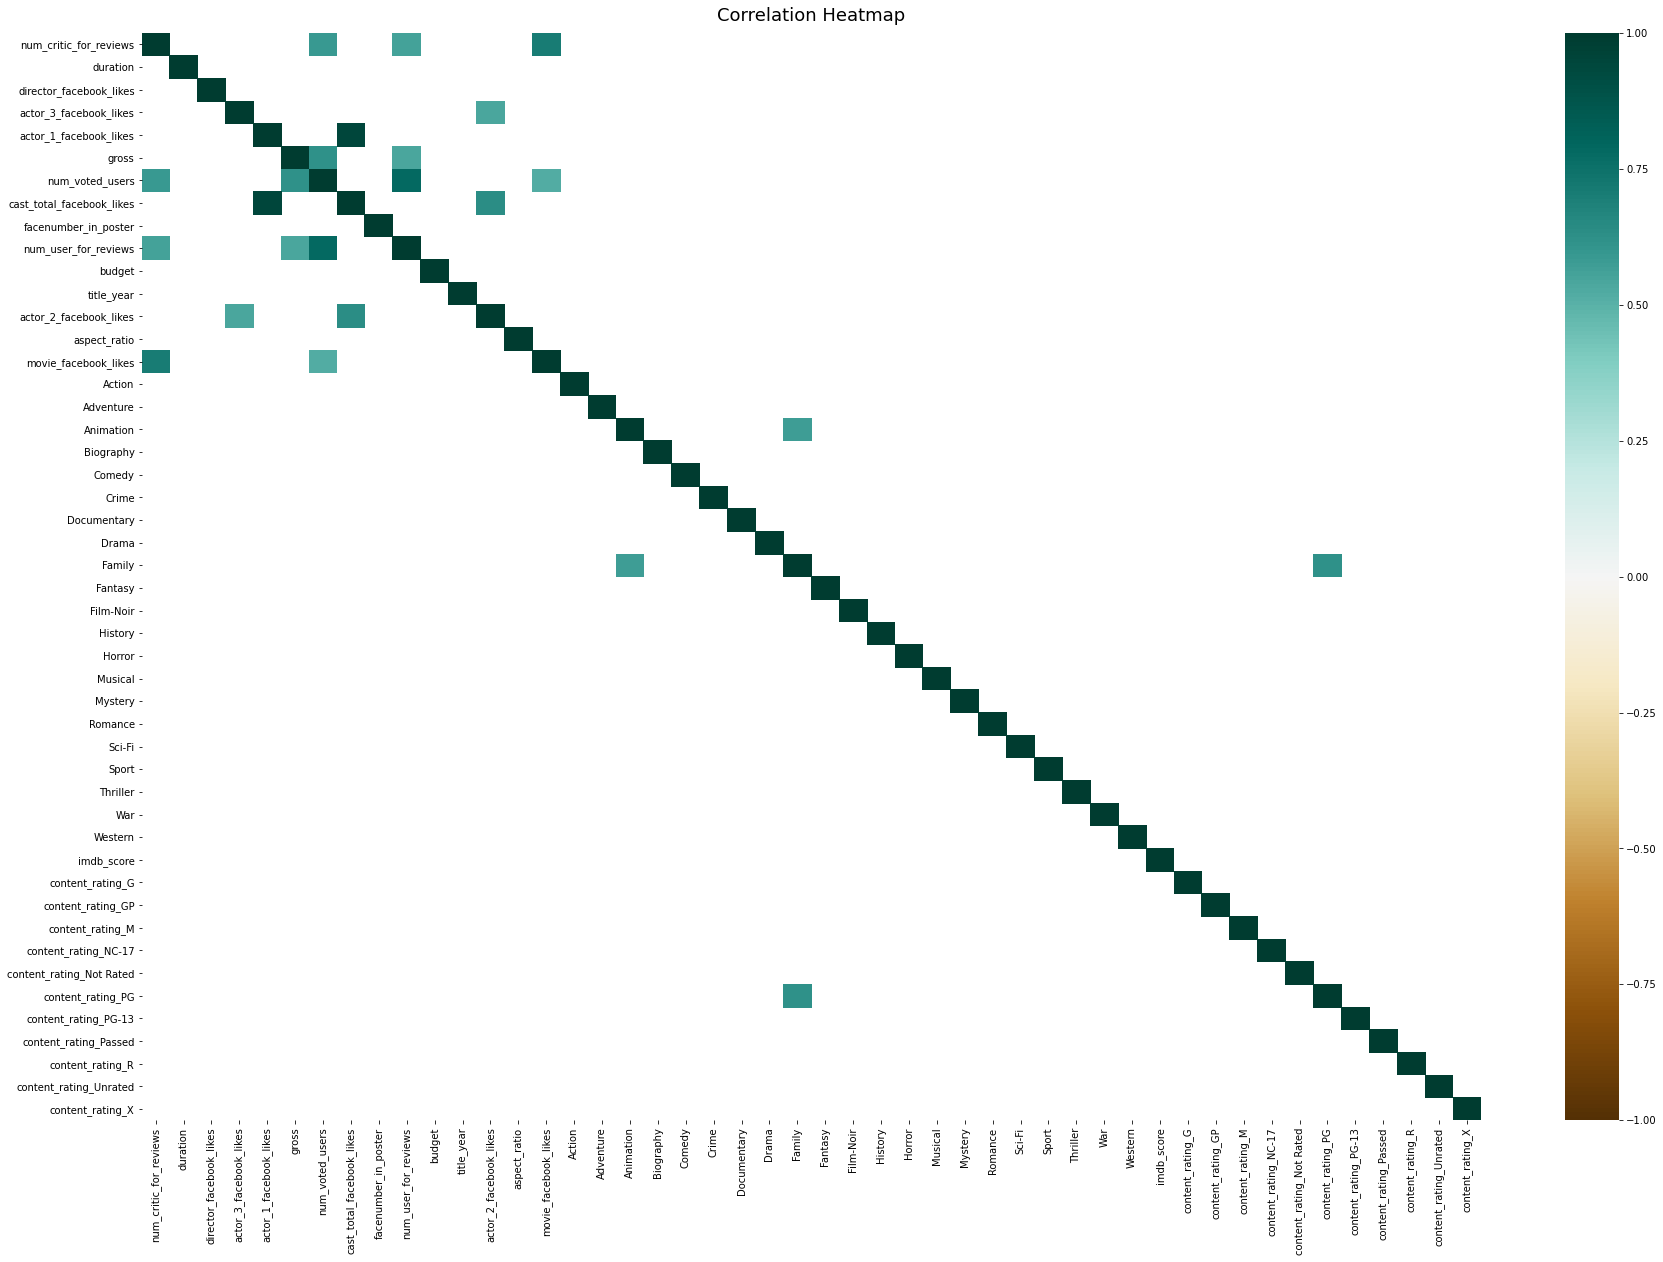

In [7]:
#Viewing the correlated variables once more to determine which variables are correlated
#Only correlations above 0.5 will be displayed to indicate what variables are causing multicollinearity.
#These variables will be removed before the EDA, feature selection, and model building steps.

plt.figure(figsize = (30, 20))
heatmap = sns.heatmap(movies.corr()[movies.corr() >= 0.5], vmin = -1, vmax = 1, cmap = 'BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad = 12);

In [8]:
#Color, languages, and plot keywords will be removed as these features will be of no use to our analysis.
#Color and language are overwhelmingly of one element, and keywords are much too different to be useful
#for building a predictive analytic model.

del movies['color']
del movies['language']
del movies['plot_keywords']

In [9]:
#In addition, variables that were shown to have high correlations with other variables will be deleted, such as number 
#of users who voted on the movie in IMDb, number of user reviews, and number of critic reviews

del movies['num_voted_users']
del movies['num_user_for_reviews']
del movies['num_critic_for_reviews']

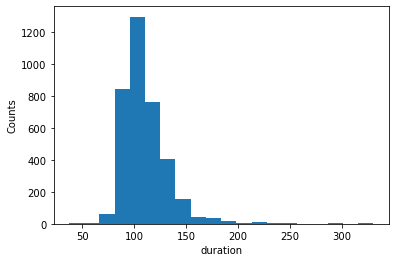

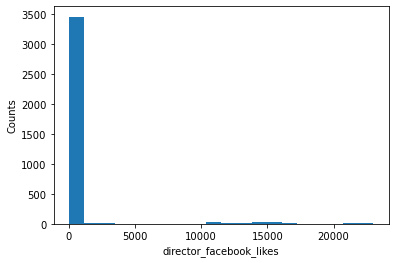

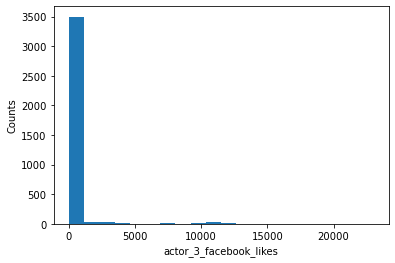

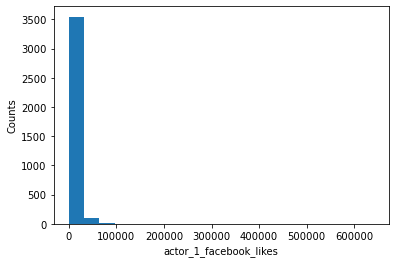

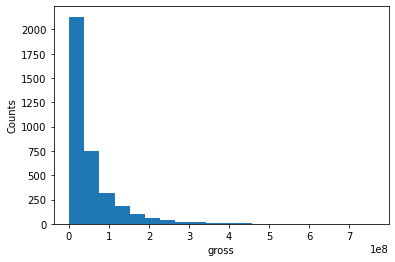

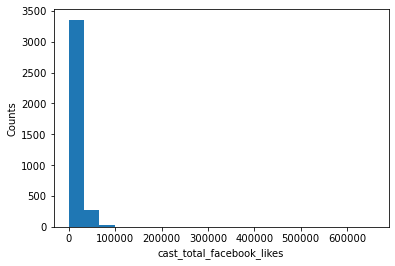

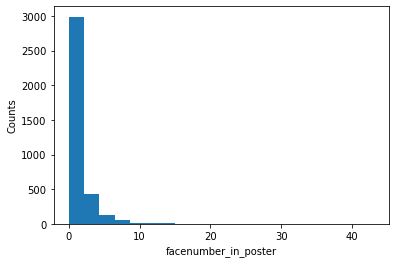

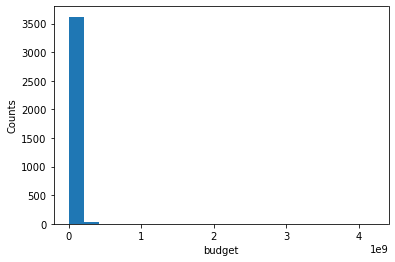

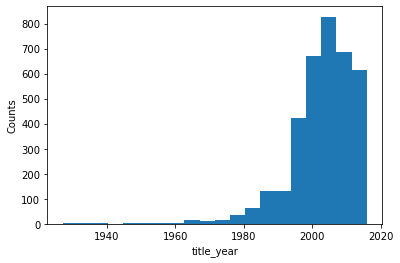

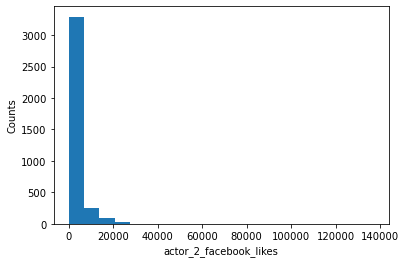

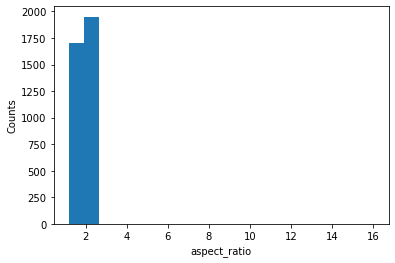

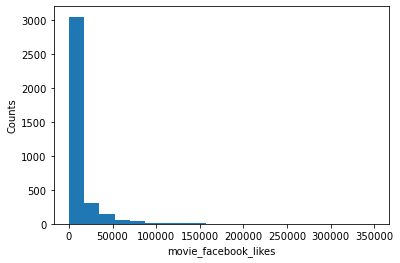

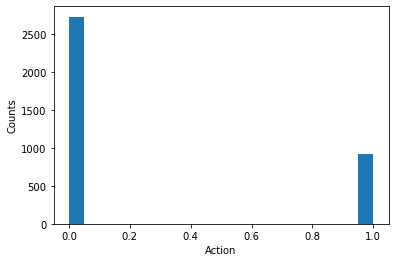

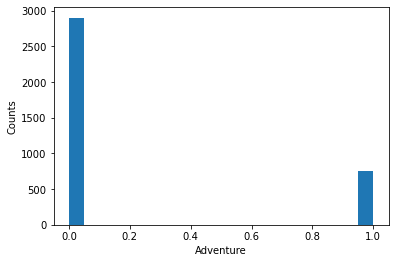

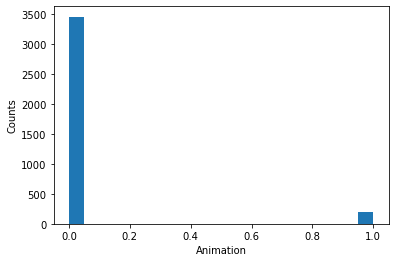

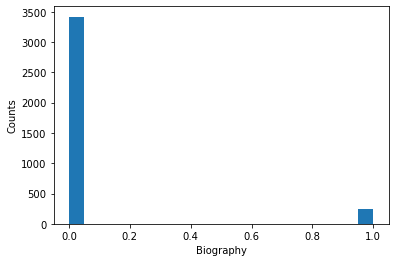

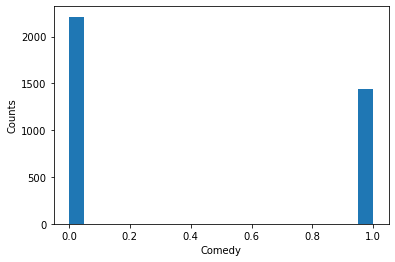

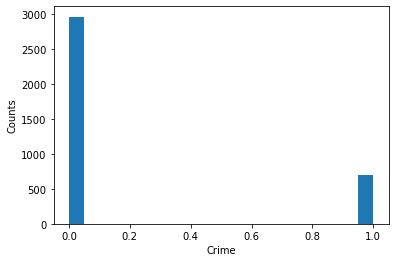

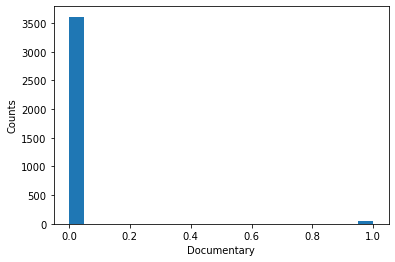

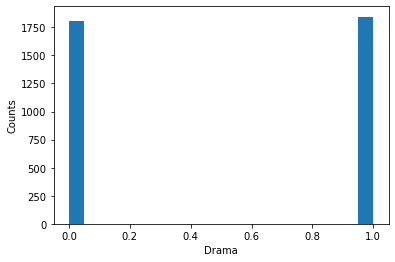

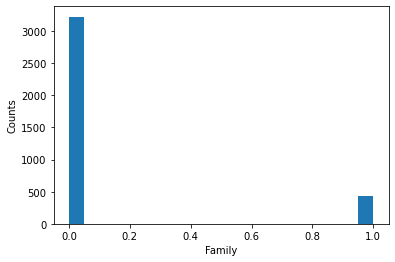

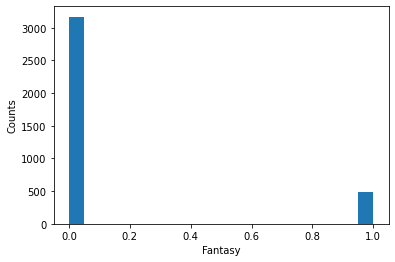

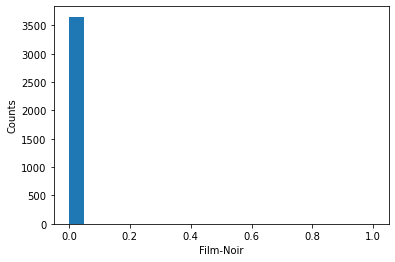

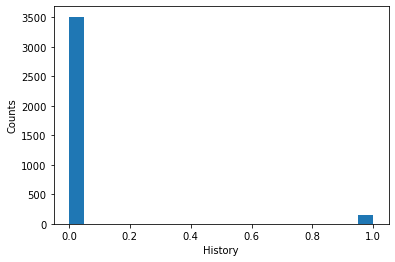

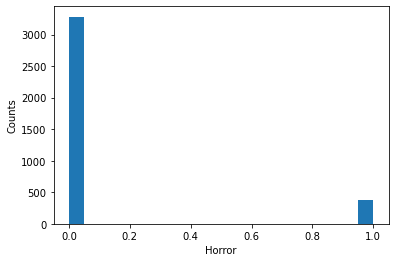

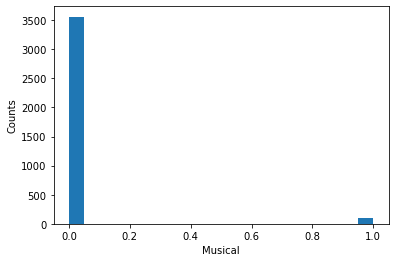

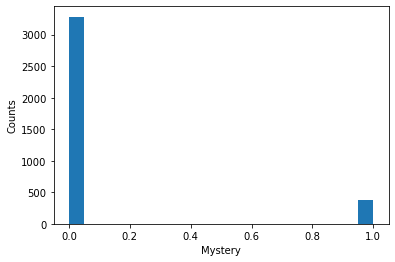

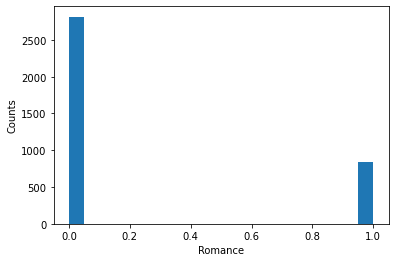

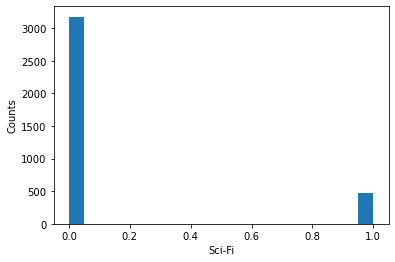

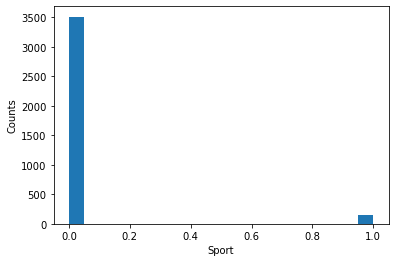

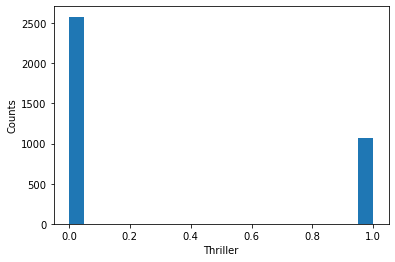

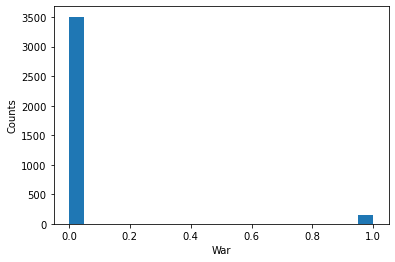

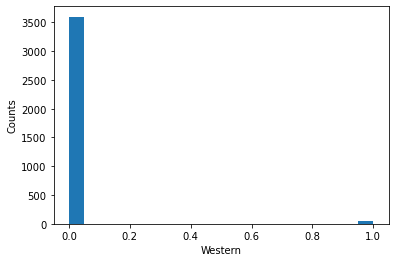

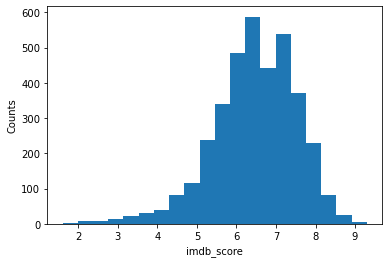

In [10]:
#Generating histograms of the numerical variables
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = movies.select_dtypes(include = numerics)

for i in range(newdf.shape[1]):
    plt.hist(newdf[newdf.columns[i]], bins = 20)
    plt.xlabel(newdf.columns[i])
    plt.ylabel('Counts')
    plt.show()

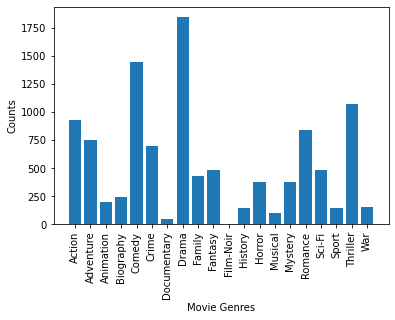

In [11]:
#Generating a bar chart of the movie genres

genre_names = movies.columns[20:40]
sums = [movies[genre].sum() for genre in genre_names]

plt.bar(genre_names, sums)
plt.xlabel('Movie Genres')
plt.ylabel('Counts')
plt.xticks(rotation = 90)
plt.show()

#It appears that Drama, Comedy, Thriller, Action, and Romance are the top 5 movie genres of all time

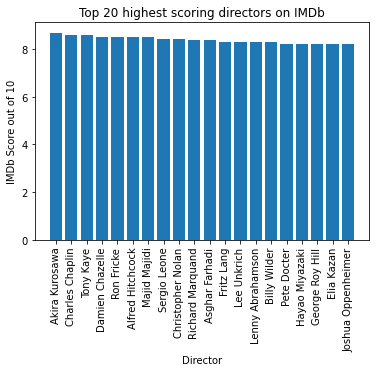

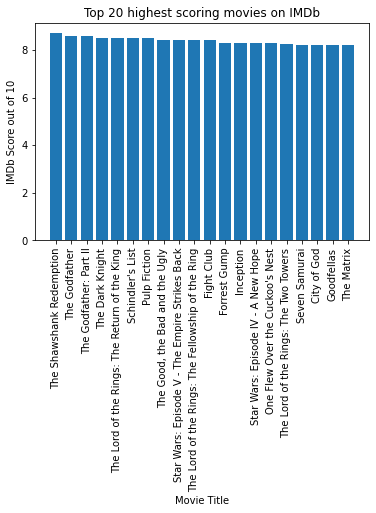

In [12]:
#Constructing a bar chart of the top 20 highest scoring film directors on IMDb and top 20 highest scoring movies on IMDb

IMDB_Score = movies.groupby('director_name').mean().sort_values(by = 'imdb_score', ascending = False)['imdb_score']

plt.bar(IMDB_Score.index[0:20], IMDB_Score[0:20])
plt.xlabel('Director')
plt.ylabel('IMDb Score out of 10')
plt.xticks(rotation = 90)
plt.title('Top 20 highest scoring directors on IMDb')
plt.show()

top20_movies = movies.sort_values(by = 'imdb_score', ascending = False)['movie_title'][0:20]

plt.bar(top20_movies, IMDB_Score[0:20])
plt.xlabel('Movie Title')
plt.ylabel('IMDb Score out of 10')
plt.xticks(rotation = 90)
plt.title('Top 20 highest scoring movies on IMDb')
plt.show()

#All 20 directors and films had scores between 8-8.5

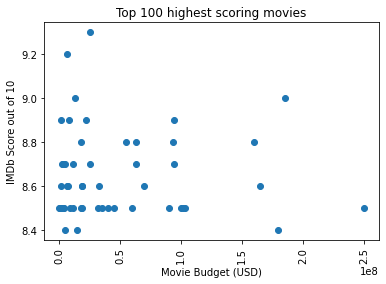

In [13]:
#Plotting IMDb score vs movie budget for the top 50 movies to see if there is a trend 
#between how much is spent on a movie and how well it does among viewers.

#Budgets for the top 50 scoring movies
top50_budgets = movies.sort_values(by = 'imdb_score', ascending = False)['budget'][0:50]

#Scores for the top 50 scoring movies
top50_scores = movies.sort_values(by = 'imdb_score', ascending = False)['imdb_score'][0:50]

plt.scatter(top50_budgets, top50_scores)
plt.xlabel('Movie Budget (USD)')
plt.ylabel('IMDb Score out of 10')
plt.title('Top 100 highest scoring movies')
plt.xticks(rotation = 90)
plt.show()

#It doesn't look like there is a trend between budget and how well a movie performs

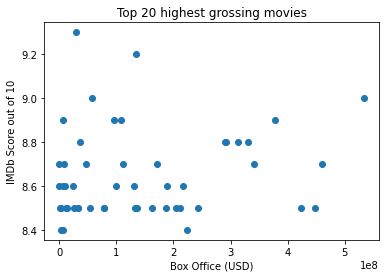

In [14]:
#What about IMDb score vs how much a movie grosses for the top 20 movies?

#Box office for the top 50 movies
top50_gross = movies.sort_values(by = 'imdb_score', ascending = False)['gross'][0:50]

#Scores for the top 50 movies
top50_scores = movies.sort_values(by = 'imdb_score', ascending = False)['imdb_score'][0:50]

plt.scatter(top50_gross, top50_scores)
plt.xlabel('Box Office (USD)')
plt.ylabel('IMDb Score out of 10')
plt.title('Top 20 highest grossing movies')
plt.show()

#Again, there appears to be no trend between how much a film grossed and its IMDb score for the top 50 films

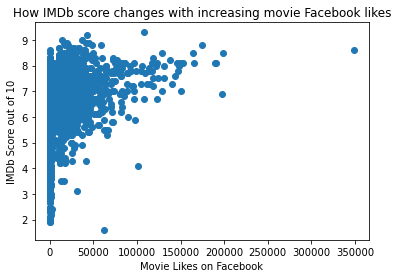

Correlation: 0.2870455013295861


In [15]:
#Plotting IMDb score vs how many likes a movie's Facebook page received.

likes = movies['movie_facebook_likes']
scores = movies['imdb_score']

plt.scatter(likes, scores)
plt.xlabel('Movie Likes on Facebook')
plt.ylabel('IMDb Score out of 10')
plt.title('How IMDb score changes with increasing movie Facebook likes')
plt.show()
print('Correlation: {}'.format(np.corrcoef(likes, scores)[0, 1]))
      
#There appears to be a weak positive correlation between IMDb score and number of Facebook likes

In [16]:
#Generating a list of the key predictors to use for the model.

predictors = ['duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross', 
              'cast_total_facebook_likes', 'facenumber_in_poster', 'budget', 'title_year', 'actor_2_facebook_likes',
              'aspect_ratio', 'movie_facebook_likes', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 
              'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Musical', 'Mystery', 'Romance', 
              'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 'content_rating_G', 'content_rating_GP', 'content_rating_M',
              'content_rating_NC-17', 'content_rating_Not Rated', 'content_rating_PG', 'content_rating_PG-13', 
              'content_rating_Passed', 'content_rating_R', 'content_rating_Unrated', 'content_rating_X']




In [17]:
#Four types of ridge regression models will be built: 

#One using KFCV 
#One using a 80-20 train-test split of the data
#One using KFCV with our dataset one-hot encoded to turn the categorical features into binary features for each element
#One using a 80-20 train-test split of the data using the same one-hot encoded features from Model 3. 
#For all models, root mean squared error (RMSE) will be used as the scoring metric.


#Method 1: Ridge regression with KFCV

#Implementing ridge regression
ridge = Ridge(alpha = .001, normalize = True)

#Defining the X (predictors) and y (target) 
X = movies[predictors]
y = movies['imdb_score']

#Scoring the model using a 10-fold cross-validation.
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
scores = cross_val_score(ridge, X , y, scoring = 'neg_mean_squared_error', cv=cv, n_jobs=-1)

#Finding absolute values.
scores = absolute(scores)

In [18]:
#Evaluating the RMSE of the model.
print('RMSE: {} ({})'.format(mean(scores), std(scores)))

RMSE: 0.6965167724434038 (0.07868203232391925)


In [19]:
#Method 2: Ridge regression with an 80-20 train-test splitX

#Splitting the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 45)

In [20]:
#Fitting the model with the training data.
ridge.fit(X_train, y_train)

Ridge(alpha=0.001, normalize=True)

In [21]:
#Generating numerical predictions.
y_pred = ridge.predict(X_test)

In [22]:
#Evaluating the RMSE of the model.
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

RMSE: 0.8291239254188921


In [23]:
#Cleaning up the data frame with categories we can't use. 
#The link isn't helpful and the genre is too diverse without helpfulness.
del moviesdf['genres']
del moviesdf['movie_imdb_link']
moviesdf.head()

NameError: name 'moviesdf' is not defined

In [ ]:
#Method 3: Ridge regression with one-hot encoded variables using KFCV

#One-hot encoding the dataframe to turn the categorical columns into binary columns for each element
moviesdf = pd.get_dummies(data = movies, columns = ['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name', 'movie_title', 'country'], drop_first = True)
moviesdf.head()

In [ ]:
#Defining a new X and y.
X = moviesdf[moviesdf.columns]
y = moviesdf['imdb_score']

In [ ]:
#Using another 10-fold cross validation.
ridge = Ridge()
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
scores = cross_val_score(ridge, moviesdf[moviesdf.columns] , movies['imdb_score'], scoring = 'neg_mean_squared_error', cv = cv, n_jobs = -1)
scores = absolute(scores)

In [ ]:
#Evaluating the RMSE of the model.
print('RMSE: {} ({})'.format(mean(scores), std(scores)))

In [ ]:
#Method 4: Ridge regression with the one-hot encoded features using an 80-20 train-test split.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 45)

In [ ]:
#Fitting the model.
ridge.fit(X_train,y_train)

In [ ]:
#Predicting the model.
y_pred = ridge.predict(X_test)

In [ ]:
#UEvaluating the RMSE of the model.
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))